<font size=7>Comparison with the whole group<font>

<font size=5>Step 1: Group averages

<font size=3>You can now compare your results with the data of the entire group.

<font size=3>•	Are there common effects in the whole group? 

<font size=3>•	Where do individual differences become apparent?

<font size=3>•	Where do you place yourself in the group?

In [10]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.io
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
#from ipywidgets import interact, Button
import ipywidgets as widgets
from IPython.display import display, HTML
from PIL import Image
#import solara
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

#im_width, im_height = 800, 600
#im_width_real, im_height_real = 1146, 876  # real size
#exp_scale_width = im_width_real / im_width  # 1.4325
#exp_scale_height = im_height_real / im_height  # 1.46


# Path to the folder containing JPG images
#IMAGE_FOLDER = '/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Jupyter/images_task_F/images'
RESULTS_FOLDER = '/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/pilot_res'

# Get a list of JPG image files in the folder
#image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jpg')]
SUBJECT_LIST = [sub[:2] for sub in os.listdir(RESULTS_FOLDER)if sub != '.DS_Store']
print(SUBJECT_LIST)
#subject_list = ['zt', 'pp']

['jp', 'pp', 'zt']


In [82]:
def extract_semantic_fix(subject_num):
    # Add necessary path
    fix_data_path = (
        "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
        + subject_num
        + "_fix_data.csv"
    )

    OSIE_data_path = "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/attrs_OSIE_40.mat"

    # Load the MATLAB .mat file containing the data
    fix_data = pd.read_csv(fix_data_path, sep=",")
    # mat_data = loadmat(OSIE_data_path)
    mat_dict = loadmat(OSIE_data_path, simplify_cells=True)
    # df = pd.read_table("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc")
    # ascii_grid = np.loadtxt("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc", skiprows=100)
    attrs_OSIE_40 = mat_dict["attrs_OSIE_40"]

    # Constants and parameters
    dims = [0, 1, 5, 7, 10]
    # Header = ["Text", "Face", "Taste", "Motion", "Touched"]

    im_width, im_height = 800, 600

    im_width_real, im_height_real = 1146, 876  # real size
    exp_scale_width = im_width_real / im_width  # 1.4325
    exp_scale_height = im_height_real / im_height  # 1.46
    screen_width, screen_height = 1920, 1080
    # screen_x_cm, screen_y_cm, vp_dist_cm = 51.5, 29.0, 60
    # sample_freq = 1000
    # XPIX2DEG = np.arctan((screen_x_cm / screen_width) / vp_dist_cm) * (180 / np.pi)
    # YPIX2DEG = np.arctan((screen_y_cm / screen_height) / vp_dist_cm) * (180 / np.pi)
    # folder_name = f"e1v{subject_num}b1"
    fixations = {}

    # im_num = '1001.jpg'
    # block_num = 1

    BLOCK_NUMS = 40
    for block_num in range(0, BLOCK_NUMS):
        # block_num = 1
        image_name = attrs_OSIE_40[block_num]["img"]
        # objs = attrs_OSIE_40[block_num]["objs"]

        fix_data_block = fix_data[fix_data["img"] == image_name]
        Cfix = len(fix_data_block)  # fixation count
        Dfix = list(fix_data_block["dur"])  # fixation durations
        Xfix = list(
            ((fix_data_block["axp"] - (screen_width / 2)) / exp_scale_width) + (im_width / 2)
        )
        Order = list(fix_data_block["fix_order"])
        # Xfix = Xfix - (screen_width/2) #/ exp_scale_width)
        # Xfix = Xfix + (im_width/2)
        # Xfix_norm = Xfix/exp_scale_width # X coord
        Yfix = list(
            ((fix_data_block["ayp"] - (screen_height / 2)) / exp_scale_height) + (im_height / 2)
        )  # / exp_scale_height)  # Y coord
        # for im_num in pd.unique(fix_data['img']):
        # Analyze semantic content
        sem = np.zeros((Cfix, len(dims)))

        for d in range(len(dims)):
            map_sum = np.zeros((im_height, im_width))
            # map_ori = []
            for obj in range(len(attrs_OSIE_40[block_num]["objs"])):
                # obj = 0
                if attrs_OSIE_40[block_num]["objs"][obj]["features"][dims[d]] > 0:
                    # print(attrs_OSIE_40[block_num-1]['objs'][obj]['features'][dims[d]])
                    map_ori = attrs_OSIE_40[block_num]["objs"][obj]["map"]
                    # print(map_ori)
                    map_sum += map_ori
                    # print(map_sum)
            for f in range(Cfix):
                sem[f, d] = 0
                if 0 < round(Xfix[f]) <= im_width and 0 < round(Yfix[f]) <= im_height:
                    sem[f, d] = map_sum[int(round(Yfix[f])), int(round(Xfix[f]))] * Dfix[f]

        fixations[image_name] = {
            "X": Xfix,
            "Y": Yfix,
            # "Onset": Tfix,
            "Duration": Dfix,
            # "Amplitude": Asac,
            "Sem": pd.DataFrame(sem),
            "Order": Order
            # "Sal": sal,
        }

    return fixations



def extract_semantic_saliency_fix(subject_num):
    # Add necessary path
    fix_data_path = (
        "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
        + subject_num
        + "_fix_data.csv"
    )

    OSIE_data_path = "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/attrs_OSIE_40.mat"

    saliency_map_path = "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/OSIE_40/saliency_map_dict.npy"

    # Load the MATLAB .mat file containing the data
    fix_data = pd.read_csv(fix_data_path, sep=",")
    # mat_data = loadmat(OSIE_data_path)
    mat_dict = loadmat(OSIE_data_path, simplify_cells=True)
    attrs_OSIE_40 = mat_dict["attrs_OSIE_40"]
    saliency_map_dict = np.load(
        saliency_map_path,
        allow_pickle="TRUE",
    ).item()

    # print(saliency_map_dict)
    # df = pd.read_table("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc")
    # ascii_grid = np.loadtxt("/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/pilot_res/pp_scan_2024_03_21_16_08.asc", skiprows=100)

    # Constants and parameters
    dims = [0, 1, 5, 7, 10]
    # Header = ["Text", "Face", "Taste", "Motion", "Touched"]

    im_width, im_height = 800, 600

    im_width_real, im_height_real = 1146, 876  # real size
    exp_scale_width = im_width_real / im_width  # 1.4325
    exp_scale_height = im_height_real / im_height  # 1.46
    screen_width, screen_height = 1920, 1080
    # screen_x_cm, screen_y_cm, vp_dist_cm = 51.5, 29.0, 60
    # sample_freq = 1000
    # XPIX2DEG = np.arctan((screen_x_cm / screen_width) / vp_dist_cm) * (180 / np.pi)
    # YPIX2DEG = np.arctan((screen_y_cm / screen_height) / vp_dist_cm) * (180 / np.pi)
    # folder_name = f"e1v{subject_num}b1"
    fixations = {}

    # im_num = '1001.jpg'
    # block_num = 1

    BLOCK_NUMS = 40
    for block_num in range(0, BLOCK_NUMS):
        # block_num = 1
        image_name = attrs_OSIE_40[block_num]["img"]
        # objs = attrs_OSIE_40[block_num]["objs"]

        fix_data_block = fix_data[fix_data["img"] == image_name]
        Cfix = len(fix_data_block)  # fixation count
        Dfix = list(fix_data_block["dur"])  # fixation durations
        Xfix = list(
            ((fix_data_block["axp"] - (screen_width / 2)) / exp_scale_width) + (im_width / 2)
        )
        # Xfix = Xfix - (screen_width/2) #/ exp_scale_width)
        # Xfix = Xfix + (im_width/2)
        # Xfix_norm = Xfix/exp_scale_width # X coord
        Yfix = list(
            ((fix_data_block["ayp"] - (screen_height / 2)) / exp_scale_height) + (im_height / 2)
        )  # / exp_scale_height)  # Y coord
        Order = list(fix_data_block["fix_order"])
        # for im_num in pd.unique(fix_data['img']):

        # Analyze semantic content
        sem = np.zeros((Cfix, len(dims)))

        for d in range(len(dims)):
            map_sum = np.zeros((im_height, im_width))
            # map_ori = []
            for obj in range(len(attrs_OSIE_40[block_num]["objs"])):
                # obj = 0
                if attrs_OSIE_40[block_num]["objs"][obj]["features"][dims[d]] > 0:
                    # print(attrs_OSIE_40[block_num-1]['objs'][obj]['features'][dims[d]])
                    map_ori = attrs_OSIE_40[block_num]["objs"][obj]["map"]
                    # print(map_ori)
                    map_sum += map_ori
                    # print(map_sum)
            for f in range(Cfix):
                sem[f, d] = 0
                if 0 < round(Xfix[f]) <= im_width and 0 < round(Yfix[f]) <= im_height:
                    sem[f, d] = map_sum[int(round(Yfix[f])), int(round(Xfix[f]))] * Dfix[f]

        sem_df = pd.DataFrame(sem)

        # Analyze saliency content
        sal = np.zeros((Cfix, len(saliency_map_dict[image_name])))
        list_of_sal_maps = list(saliency_map_dict[image_name].keys())

        for i, sal_map in enumerate(list_of_sal_maps):
            # print(i, sal_map)
            sal_map_ori = saliency_map_dict[image_name][sal_map]

            for f in range(Cfix):
                sal[f, i] = 0
                if 0 < round(Xfix[f]) <= im_width and 0 < round(Yfix[f]) <= im_height:
                    # sal[f, i] = sal_map_ori[int(round(Yfix[f])), int(round(Xfix[f]))] * Dfix[f]
                    sal[f, i] = (
                        np.sum(sal_map_ori < sal_map_ori[int(round(Yfix[f])), int(round(Xfix[f]))])
                        / sal_map_ori.size
                    )  # * Dfix[f]

        sal_df = pd.DataFrame(sal, columns=list_of_sal_maps)

        fixations[image_name] = {
            "X": Xfix,
            "Y": Yfix,
            # "Onset": Tfix,
            "Duration": Dfix,
            # "Amplitude": Asac,
            "Sem": sem_df,
            "Sal": sal_df,
            "Order": Order,
        }

    return fixations



def plot_fixations_semantic_group():
    # subject_list = ['zt','pp','jp']
    sem_fix_dataframe_group = pd.DataFrame()
    for subject_num in SUBJECT_LIST:
        
        # subject_num='zt'
        fixations = extract_semantic_saliency_fix(subject_num)
        # Constants and parameters
        dims = [0, 1, 5, 7, 10]
        header = ["Text", "Face", "Taste", "Motion", "Touched"]
    
        first_fix = []
        all_fix = pd.DataFrame()
        # d_fix = []
        all_dur = []  # pd.DataFrame()
        fixation_keys = list(fixations.keys())
    
        for key in fixation_keys:
            # key = '1001.jpg'
            if fixations[key] is not None:
                first_fix.append(fixations[key]["Sem"].iloc[0])
    
                df_sem = pd.DataFrame(fixations[key]["Sem"])
                df_dur = fixations[key]["Duration"]
    
                all_fix = pd.concat([all_fix, df_sem])
                all_dur += df_dur
    
        first_prop = np.sum(np.sign(first_fix), axis=0) / len(first_fix)
        # all_prop = np.sum(all_fix, axis=0) / np.sum(d_fix)
        all_prop = all_fix.sum() / sum(all_dur)

        # sem_fix_data = pd.DataFrame((np.array(header), first_prop, np.array(all_prop))).T.rename(columns={0:'header', 1:'first_prop', 2:'all_prop'})
        sem_fix_data = {"header": header, "first_prop": list(first_prop), "all_prop": list(all_prop)}
        sem_fix_dataframe_ind = pd.DataFrame(sem_fix_data, columns=["header", "first_prop", "all_prop"])
        sem_fix_dataframe_ind['sub_num'] = subject_num
        
        sem_fix_dataframe_group = pd.concat([sem_fix_dataframe_group, sem_fix_dataframe_ind])

        
    # Defining the x-axis, the y-axis and the data
    # from where the values are to be taken
    fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
    for i, y_value in enumerate(["first_prop", "all_prop"]):
        sns.barplot(x="header", y=y_value, data=sem_fix_dataframe_group, ax=ax[i], color='grey', alpha=0.7)
        sns.stripplot(x="header", y=y_value, data=sem_fix_dataframe_group, ax=ax[i], hue='sub_num', dodge=True)#color='grey')
        ax[i].set_ylim([0, 1])
        ax[i].tick_params(axis="x", rotation=45)
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("Semantic category", size=15)
        ax[i].grid(True)
        if i == 0:
            ax[i].set_ylabel("Proportion of fixations", size=15)
            ax[0].set_title("First fixation [Group]")
        else:
            ax[i].set_ylabel("Proportion of cumulative fixation duration", size=15)
            ax[1].set_title("All fixations [Group]")

    ax[0].legend().set_visible(False)
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0).set_visible(True)
    plt.show()


def plot_fixations_salience_group():
    #subject_list = ["zt", "pp", "jp"]
    sal_fix_dataframe_group = pd.DataFrame()
    for subject_num in SUBJECT_LIST:
        # fixations = extract_semantic_fix(subject_num)
        fixations = extract_semantic_saliency_fix(subject_num)
        # Constants and parameters
        header = ["Saliency", "Intensity", "Color", "Orientation"]

        first_fix = []  # pd.DataFrame()
        all_fix = pd.DataFrame()
        fixation_keys = list(fixations.keys())

        for key in fixation_keys:
            if fixations[key] is not None:
                first_fix.append(fixations[key]["Sal"].iloc[0])
                df_sal = fixations[key]["Sal"]
                all_fix = pd.concat([all_fix, df_sal])

        first_fix_df = pd.DataFrame(first_fix)
        first_prop = first_fix_df.mean()
        all_prop = all_fix.mean()

        # sem_fix_data = pd.DataFrame((np.array(header), first_prop, np.array(all_prop))).T.rename(columns={0:'header', 1:'first_prop', 2:'all_prop'})
        sal_fix_data = {
            "header": header,
            "first_prop": list(first_prop),
            "all_prop": list(all_prop),
        }
        sal_fix_dataframe_ind = pd.DataFrame(
            sal_fix_data, columns=["header", "first_prop", "all_prop"]
        )

        sal_fix_dataframe_ind["sub_num"] = subject_num

        sal_fix_dataframe_group = pd.concat([sal_fix_dataframe_group, sal_fix_dataframe_ind])

    # Defining the x-axis, the y-axis and the data
    # from where the values are to be taken
    fig, ax = plt.subplots(figsize=(12, 5), ncols=2)
    # plt.figure(figsize=(8, 6))
    for i, y_value in enumerate(["first_prop", "all_prop"]):
        sns.barplot(
            x="header", y=y_value, data=sal_fix_dataframe_group, ax=ax[i], color="grey", alpha=0.7
        )
        sns.stripplot(
            x="header", y=y_value, data=sal_fix_dataframe_group, ax=ax[i], hue="sub_num", dodge=True
        )  # color='grey')
        ax[i].set_ylim([0, 1])
        ax[i].tick_params(axis="x", rotation=45)
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("Saliency feature", size=15)
        ax[i].grid(True)
        if i == 0:
            ax[i].set_ylabel("Percent fixated", size=15)
            ax[0].set_title("First fixation [Group]")
        else:
            ax[i].set_ylabel("Percent fixated", size=15)
            ax[1].set_title("All fixations [Group]")

    ax[0].legend().set_visible(False)
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0).set_visible(True)
    plt.show()



def plot_fixations_semantic_group_plotly():
    # subject_list = ['zt','pp','jp']
    sem_fix_dataframe_group = pd.DataFrame()
    for subject_num in SUBJECT_LIST:
        
        # subject_num='zt'
        fixations = extract_semantic_saliency_fix(subject_num)
        # Constants and parameters
        dims = [0, 1, 5, 7, 10]
        header = ["Text", "Face", "Taste", "Motion", "Touched"]
    
        first_fix = []
        all_fix = pd.DataFrame()
        # d_fix = []
        all_dur = []  # pd.DataFrame()
        fixation_keys = list(fixations.keys())
    
        for key in fixation_keys:
            # key = '1001.jpg'
            if fixations[key] is not None:
                first_fix.append(fixations[key]["Sem"].iloc[0])
    
                df_sem = pd.DataFrame(fixations[key]["Sem"])
                df_dur = fixations[key]["Duration"]
    
                all_fix = pd.concat([all_fix, df_sem])
                all_dur += df_dur
    
        first_prop = np.sum(np.sign(first_fix), axis=0) / len(first_fix)
        # all_prop = np.sum(all_fix, axis=0) / np.sum(d_fix)
        all_prop = all_fix.sum() / sum(all_dur)

        # sem_fix_data = pd.DataFrame((np.array(header), first_prop, np.array(all_prop))).T.rename(columns={0:'header', 1:'first_prop', 2:'all_prop'})
        sem_fix_data = {"header": header, "first_prop": list(first_prop), "all_prop": list(all_prop)}
        sem_fix_dataframe_ind = pd.DataFrame(sem_fix_data, columns=["header", "first_prop", "all_prop"])
        sem_fix_dataframe_ind['sub_num'] = subject_num
        
        sem_fix_dataframe_group = pd.concat([sem_fix_dataframe_group, sem_fix_dataframe_ind])
   
    # Create subplots with two columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=("First fixation [Group]", "All fixations [Group]"))
    
    # Define colors for the stripplot
    colors = px.colors.qualitative.Safe
    
    # First subplot
    y_value = "first_prop"
    # Group by header and calculate mean for each category
    group_averages = sem_fix_dataframe_group.groupby('header')[y_value].mean().reset_index()
    # Get the order of categories from the header
    category_order = group_averages["header"].tolist()
    # Barplot with error bars
    fig.add_trace(go.Bar(x=group_averages["header"], y=group_averages[y_value],
                         name=y_value, marker_color='grey', opacity=0.7,
                         error_y=dict(type='data', array=sem_fix_dataframe_group.groupby('header')[y_value].sem().tolist())),
                  row=1, col=1)
    # Stripplot
    for j, sub_num in enumerate(sem_fix_dataframe_group['sub_num'].unique()):
        fig.add_trace(go.Scatter(x=sem_fix_dataframe_group[sem_fix_dataframe_group['sub_num']==sub_num]['header'],
                                  y=sem_fix_dataframe_group[sem_fix_dataframe_group['sub_num']==sub_num][y_value],
                                  mode='markers',
                                  name='Subgroup ' + str(sub_num),
                                  marker=dict(color=colors[j]),
                                  legendgroup='subgroup_'+str(sub_num)), row=1, col=1)
    # Update layout
    fig.update_xaxes(title_text="Semantic category", row=1, col=1, categoryorder='array', categoryarray=category_order)
    fig.update_yaxes(title_text="Proportion of fixations", row=1, col=1, range=[0, 1])
    fig.update_layout(xaxis_tickangle=45, plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'), yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    fig.update_layout(title_text="Fixation Proportion by Semantic Category")
    #fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
    #              yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    
    # Second subplot
    y_value = "all_prop"
    # Group by header and calculate mean for each category
    group_averages = sem_fix_dataframe_group.groupby('header')[y_value].mean().reset_index()
    # Get the order of categories from the header
    category_order = group_averages["header"].tolist()
    # Barplot with error bars
    fig.add_trace(go.Bar(x=group_averages["header"], y=group_averages[y_value],
                         name=y_value, marker_color='grey', opacity=0.7,
                         error_y=dict(type='data', array=sem_fix_dataframe_group.groupby('header')[y_value].sem().tolist())),
                  row=1, col=2)
    # Stripplot
    for j, sub_num in enumerate(sem_fix_dataframe_group['sub_num'].unique()):
        fig.add_trace(go.Scatter(x=sem_fix_dataframe_group[sem_fix_dataframe_group['sub_num']==sub_num]['header'],
                                  y=sem_fix_dataframe_group[sem_fix_dataframe_group['sub_num']==sub_num][y_value],
                                  mode='markers',
                                  name='Subgroup ' + str(sub_num),
                                  marker=dict(color=colors[j]),
                                  legendgroup='subgroup_'+str(sub_num)), row=1, col=2)
    # Update layout
    fig.update_xaxes(title_text="Semantic category", row=1, col=2, categoryorder='array', categoryarray=category_order)
    fig.update_yaxes(title_text="Proportion of cumulative fixation duration", row=1, col=2, range=[0, 1])
    fig.update_layout(xaxis_tickangle=45, plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'), yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    #fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
    #              yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    
    # Show plot
    fig.show()




def plot_fixations_salience_group_plotly():
    subject_list = ["zt", "pp", "jp"]
    sal_fix_dataframe_group = pd.DataFrame()
    saliency_features = ["Saliency", "Intensity", "Color", "Orientation"]
    
    for subject_num in subject_list:
        fixations = extract_semantic_saliency_fix(subject_num)

        first_fix = []
        all_fix = pd.DataFrame()
        fixation_keys = list(fixations.keys())

        for key in fixation_keys:
            if fixations[key] is not None:
                first_fix.append(fixations[key]["Sal"].iloc[0])
                df_sal = fixations[key]["Sal"]
                all_fix = pd.concat([all_fix, df_sal])

        first_fix_df = pd.DataFrame(first_fix)
        first_prop = first_fix_df.mean()
        all_prop = all_fix.mean()

        sal_fix_data = {
            "header": saliency_features,
            "first_prop": list(first_prop),
            "all_prop": list(all_prop),
        }
        sal_fix_dataframe_ind = pd.DataFrame(
            sal_fix_data, columns=["header", "first_prop", "all_prop"]
        )

        sal_fix_dataframe_ind["sub_num"] = subject_num

        sal_fix_dataframe_group = pd.concat([sal_fix_dataframe_group, sal_fix_dataframe_ind])

 # Create subplots with two columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=("First fixation [Group]", "All fixations [Group]"))
    
    # Define colors for the stripplot
    colors = px.colors.qualitative.Safe
    
    # First subplot
    y_value = "first_prop"
    # Group by header and calculate mean for each category
    group_averages = sal_fix_dataframe_group.groupby('header')[y_value].mean().reset_index()
    # Get the order of categories from the header
    category_order = group_averages["header"].tolist()
    # Barplot with error bars
    fig.add_trace(go.Bar(x=group_averages["header"], y=group_averages[y_value],
                         name=y_value, marker_color='grey', opacity=0.7,
                         error_y=dict(type='data', array=sal_fix_dataframe_group.groupby('header')[y_value].sem().tolist())),
                  row=1, col=1)
    # Stripplot
    for j, sub_num in enumerate(sal_fix_dataframe_group['sub_num'].unique()):
        fig.add_trace(go.Scatter(x=sal_fix_dataframe_group[sal_fix_dataframe_group['sub_num']==sub_num]['header'],
                                  y=sal_fix_dataframe_group[sal_fix_dataframe_group['sub_num']==sub_num][y_value],
                                  mode='markers',
                                  name='Subgroup ' + str(sub_num),
                                  marker=dict(color=colors[j]),
                                  legendgroup='subgroup_'+str(sub_num)), row=1, col=1)
    # Update layout
    fig.update_xaxes(title_text="Salience feature", row=1, col=1, categoryorder='array', categoryarray=category_order)
    fig.update_yaxes(title_text="Proportion of fixations", row=1, col=1, range=[0, 1])
    fig.update_layout(xaxis_tickangle=45, plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'), yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    fig.update_layout(title_text="Fixation Proportion by Salience Feature")
    #fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
    #              yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))

    # Second subplot
    y_value = "all_prop"
    # Group by header and calculate mean for each category
    group_averages = sal_fix_dataframe_group.groupby('header')[y_value].mean().reset_index()
    # Get the order of categories from the header
    category_order = group_averages["header"].tolist()
    # Barplot with error bars
    fig.add_trace(go.Bar(x=group_averages["header"], y=group_averages[y_value],
                         name=y_value, marker_color='grey', opacity=0.7,
                         error_y=dict(type='data', array=sal_fix_dataframe_group.groupby('header')[y_value].sem().tolist())),
                  row=1, col=2)
    # Stripplot
    for j, sub_num in enumerate(sal_fix_dataframe_group['sub_num'].unique()):
        fig.add_trace(go.Scatter(x=sal_fix_dataframe_group[sal_fix_dataframe_group['sub_num']==sub_num]['header'],
                                  y=sal_fix_dataframe_group[sal_fix_dataframe_group['sub_num']==sub_num][y_value],
                                  mode='markers',
                                  name='Subgroup ' + str(sub_num),
                                  marker=dict(color=colors[j]),
                                  legendgroup='subgroup_'+str(sub_num)), row=1, col=2)
    # Update layout
    fig.update_xaxes(title_text="Salience feature", row=1, col=2, categoryorder='array', categoryarray=category_order)
    fig.update_yaxes(title_text="Proportion of cumulative fixation duration", row=1, col=2, range=[0, 1])
    fig.update_layout(xaxis_tickangle=45, plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'), yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    #fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
    #              yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    
    # Show plot
    fig.show()



def plot_heatmap_group():
    im_width = 800
    im_height = 600
    
    first_map_group = np.zeros((im_height, im_width))
    all_map_group = np.zeros((im_height, im_width))
    whole_duration_group = 0
    fixation_count = 0
    subject_list = ['zt','pp','jp']
    for subject_num in subject_list:

    # Load fixations data from .mat file
        fixations = extract_semantic_saliency_fix(subject_num) #subject_num
    
        x = np.arange(1, im_width + 1)
        y = np.arange(1, im_height + 1)
        x, y = np.meshgrid(x, y)
    
        first_map = np.zeros((im_height, im_width))
        all_map = np.zeros((im_height, im_width))
        fix_num = 0
        whole_duration = 0
        fixation_count += len(fixations)
        
        for key in fixations.keys():
            # key = '1001.jpg'
            if fixations[key] is not None:
                for f in range(len(fixations[key]["X"])):
                    ex = fixations[key]["X"][f]
                    ey = fixations[key]["Y"][f]
                    duration = fixations[key]["Duration"][f]
                    # whole_duration += duration
                    whole_duration_group += duration
                    dx = x - ex
                    dy = y - ey
                    r = np.hypot(dx, dy)
                    # all_map += duration * norm.pdf(r, 0, 30) / norm.pdf(0, 0, 30)
                    all_map_group += duration * norm.pdf(r, 0, 30) / norm.pdf(0, 0, 30)
                    fix_num += 1
                    if f == 0:
                        # first_map += norm.pdf(r, 0, 30) / norm.pdf(0, 0, 30)
                        first_map_group += norm.pdf(r, 0, 30) / norm.pdf(0, 0, 30)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    first_map_group /= fixation_count#len(fixations)
    axs[0].imshow(first_map_group, cmap="viridis")
    axs[0].plot([0, im_width], [im_height / 2, im_height / 2], "w--")
    axs[0].plot([im_width / 2, im_width / 2], [0, im_height], "w--")
    axs[0].set_title("First fixation [Group]")
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].set_ylim(im_height, 0)  # Reverse y-axis
    plt.colorbar(axs[0].imshow(first_map_group, cmap="viridis"), ax=axs[0], location='bottom')

    all_map_group /= whole_duration_group
    all_map_smoothed = gaussian_filter(all_map_group, sigma=2)  # Adjust sigma as needed
    axs[1].imshow(all_map_smoothed, cmap="viridis")  # Use the smoothed map
    axs[1].plot([0, im_width], [im_height / 2, im_height / 2], "w--")
    axs[1].plot([im_width / 2, im_width / 2], [0, im_height], "w--")
    axs[1].set_title("All fixations (Smoothed) [Group]")
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    axs[1].set_ylim(im_height, 0)  # Reverse y-axis
    plt.colorbar(axs[1].imshow(all_map_smoothed, cmap="viridis"), ax=axs[1], location = 'bottom')
    
    plt.show()



def plot_eye_movement_distributions_group():
    fix_data_group = pd.DataFrame()
    sacc_data_group = pd.DataFrame()
    
    subject_list = SUBJECT_LIST
    
    for subject_num in subject_list:
    
        fix_data_path = (
            "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
            + subject_num
            + "_fix_data.csv"
        )
        fix_data_ind = pd.read_csv(fix_data_path, sep=",")
        fix_data_ind['sub_num'] = subject_num
        
        sacc_data_path = (
            "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
            + subject_num
            + "_sacc_data.csv"
        )
        sacc_data_ind = pd.read_csv(sacc_data_path, sep=",")
        sacc_data_ind['sub_num'] = subject_num

        fix_data_group = pd.concat([fix_data_group, fix_data_ind])
        sacc_data_group = pd.concat([sacc_data_group, sacc_data_ind])
    
    # fig_dur = sns.ecdfplot(data=fix_data_group, x='dur', hue='sub_num')
    # fig_dur.set_xlabel("Fixation duration [s]")
    # fig_dur.set_ylabel("Cumulative proportion")
    # fig_dur.set_title("Fixation Duration Distribution")
    # plt.show()
    
    # fig_ampli = sns.ecdfplot(data=sacc_data_group, x='ampl', hue='sub_num')
    # fig_ampli.set_xlabel("Fixation duration [s]")
    # fig_ampli.set_ylabel("Cumulative proportion")
    # fig_ampli.set_title("Fixation Duration Distribution")
    # plt.show()

    fig, axs = plt.subplots(2,1)
    plt.subplot(2, 1, 1)
    sns.boxplot(fix_data_group['dur'], showmeans=True)
    axs[0].set(xticklabels=[])
    axs[0].set_title("Fixation Duration Distribution [Group]")
    plt.subplot(2, 1, 2)
    sns.ecdfplot(data=fix_data_group, x='dur', color='blue', hue='sub_num')
    axs[1].set_xlabel("Fixation duration [s]")
    axs[1].set_ylabel("Cumulative proportion")
    plt.show()
    
    fig, axs = plt.subplots(2,1)
    plt.subplot(2, 1, 1)
    sns.boxplot(sacc_data_group['ampl'], showmeans=True, color='orange')
    axs[0].set(xticklabels=[])
    axs[0].set_title("Saccade Amplitude Distribution [Group]")
    plt.subplot(2, 1, 2)
    sns.ecdfplot(data=sacc_data_group, x='ampl', color='orange', hue='sub_num')
    axs[1].set_xlabel("Saccade amplitude [deg]")
    axs[1].set_ylabel("Cumulative proportion")
    plt.show()


def plot_eye_movement_distributions_group_plotly():
    fix_data_group = pd.DataFrame()
    sacc_data_group = pd.DataFrame()
    
    subject_list = SUBJECT_LIST
    
    for subject_num in subject_list:
    
        fix_data_path = (
            "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
            + subject_num
            + "_fix_data.csv"
        )
        fix_data_ind = pd.read_csv(fix_data_path, sep=",")
        fix_data_ind['sub_num'] = subject_num
        
        sacc_data_path = (
            "/Users/patrikpolgari/Documents/Postdoc_Marburg/student_supervision/Teaching/B-NP2_Übung/Code/Task_C/data/derivatives/"
            + subject_num
            + "_sacc_data.csv"
        )
        sacc_data_ind = pd.read_csv(sacc_data_path, sep=",")
        sacc_data_ind['sub_num'] = subject_num

        fix_data_group = pd.concat([fix_data_group, fix_data_ind])
        sacc_data_group = pd.concat([sacc_data_group, sacc_data_ind])
        
    # Plotly doesn't have built-in support for boxplots, so we'll use a violin plot instead
    fig1 = make_subplots(rows=2, cols=1, subplot_titles=("Fixation Duration Distribution [Group]", "Cumulative Duration [Group]"))
    
    # Violin plot for fixation duration distribution
    fig1.add_trace(go.Violin(x=fix_data_group['dur'], box_visible=True, meanline_visible=True, showlegend=False, orientation='h'), row=1, col=1)

    # ECDF plot for cumulative proportion
    ecdf_fig1 = px.ecdf(fix_data_group, x='dur', color='sub_num')
    for trace in ecdf_fig1.data:
        fig1.add_trace(trace, row=2, col=1)
        fig1.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
        
    
    # Update layout
    fig1.update_layout(height=600, width=800)#, title_text="Fixation Duration Distribution and Cumulative Duration")
    # Set the background color to white
    fig1.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    
    # Update axes
    fig1.update_xaxes(title_text="Fixation duration [s]", row=2, col=1)
    fig1.update_yaxes(title_text="Cumulative proportion", row=2, col=1)
    
    # Show plot
    fig1.show()

    
    #Plotly doesn't have built-in support for boxplots, so we'll use a violin plot instead
    fig2 = make_subplots(rows=2, cols=1, subplot_titles=("Saccade Amplitude Distribution [Group]", "Cumulative proportion [Group]"))
    
    # Violin plot for fixation duration distribution
    fig2.add_trace(go.Violin(x=sacc_data_group['ampl'], box_visible=True, meanline_visible=True, showlegend=False, orientation='h', line_color='orange'), row=1, col=1)

    # ECDF plot for cumulative proportion
    ecdf_fig2 = px.ecdf(sacc_data_group, x='ampl', color='sub_num')
    for trace in ecdf_fig2.data:
        fig2.add_trace(trace, row=2, col=1)
        fig2.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
        
    
    # Update layout
    fig2.update_layout(height=600, width=800)#, title_text="Saccade Amplitude Distribution and Cumulative Duration")
    # Set the background color to white
    fig2.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'))
    
    # Update axes
    fig2.update_xaxes(title_text="Saccade amplitude [deg]", row=2, col=1)
    fig2.update_yaxes(title_text="Cumulative proportion", row=2, col=1)
    
    # Show plot
    fig2.show()

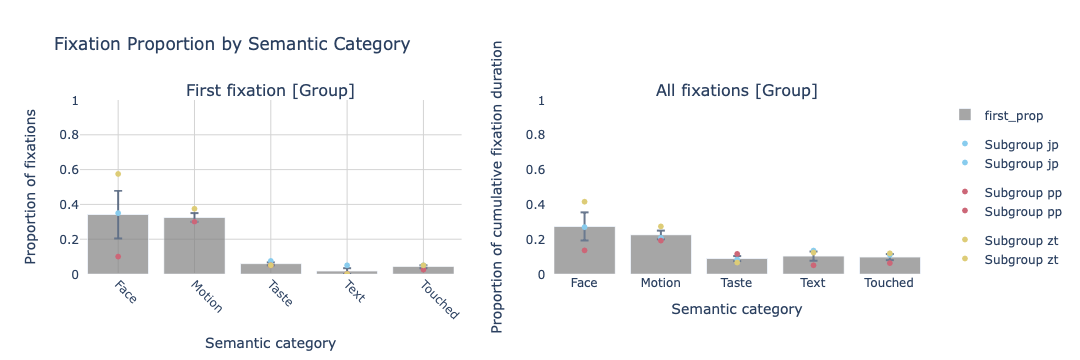

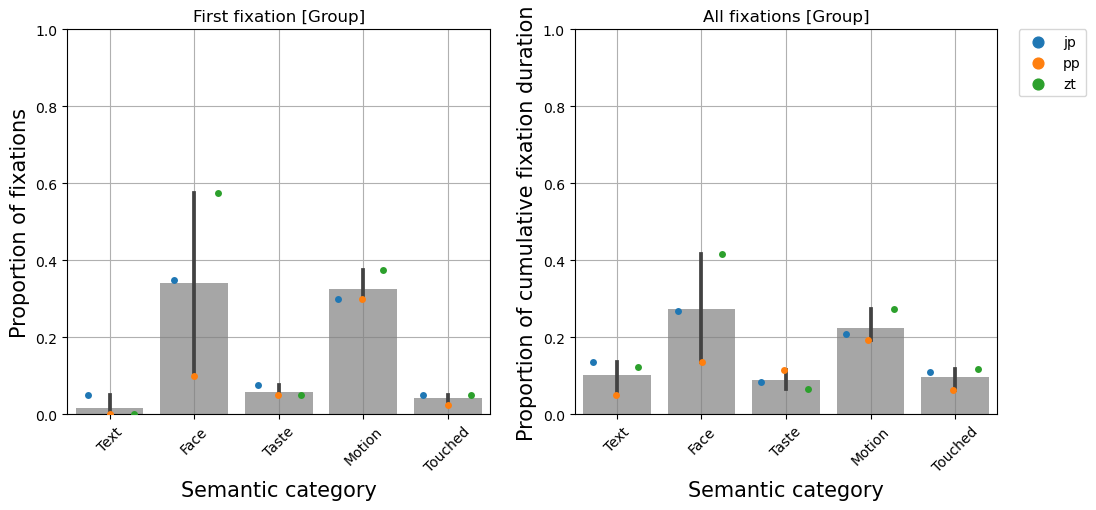

In [12]:
plot_fixations_semantic_group_plotly()
plot_fixations_semantic_group()


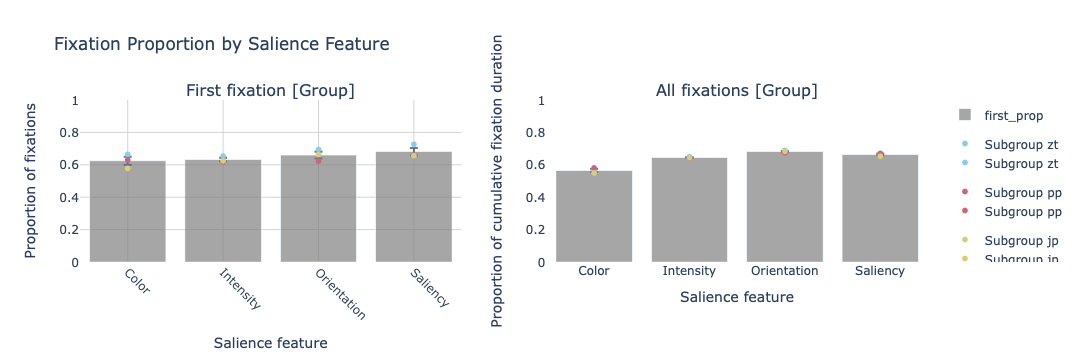

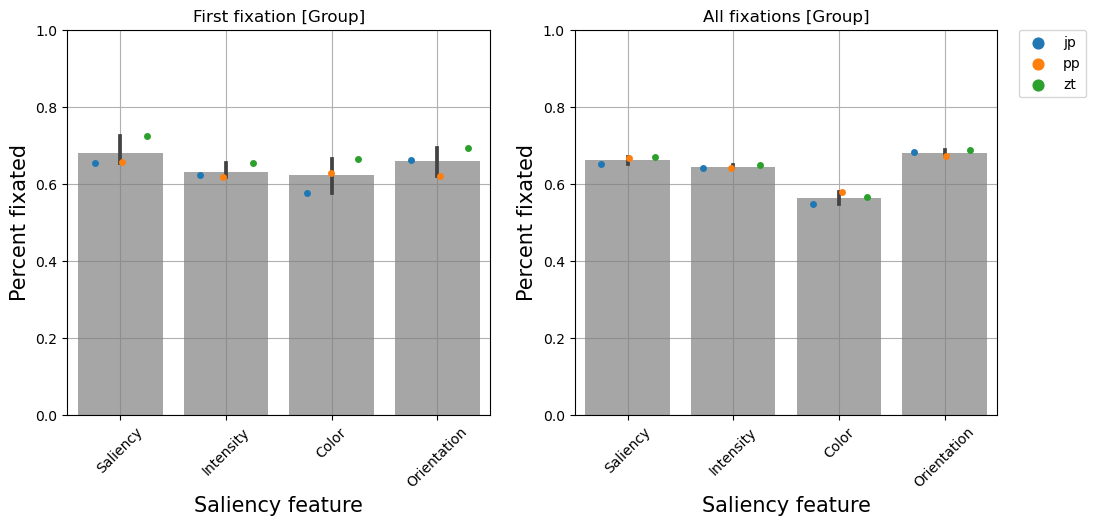

In [66]:
plot_fixations_salience_group_plotly()
plot_fixations_salience_group()

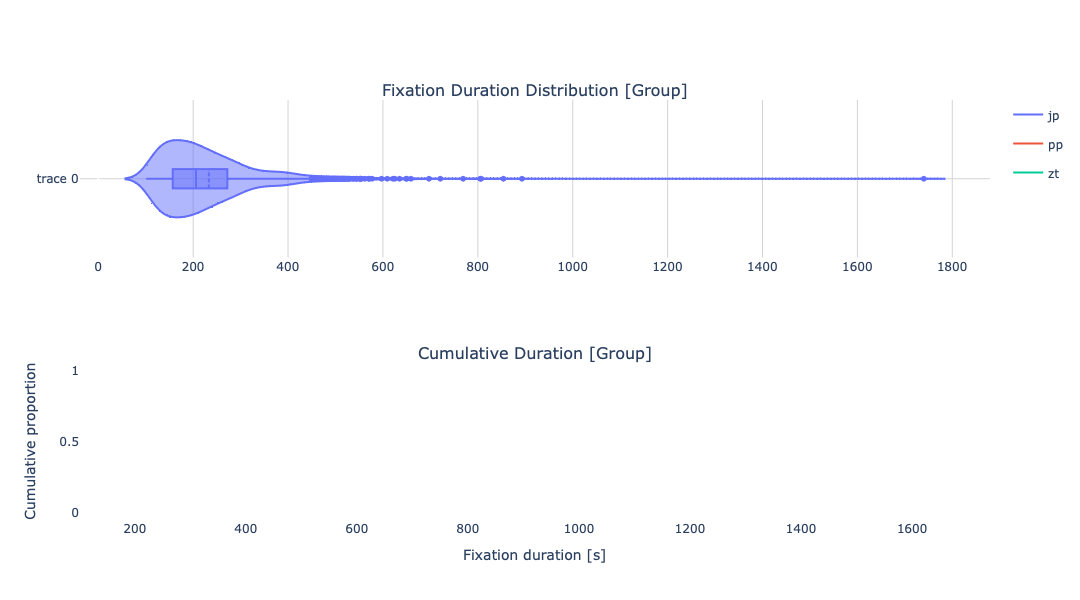

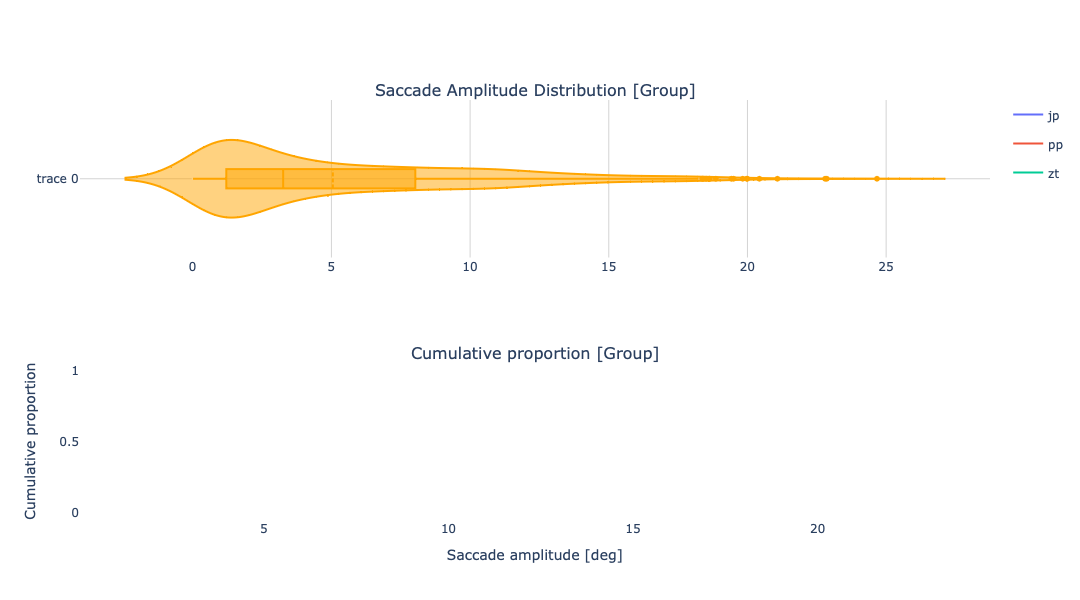

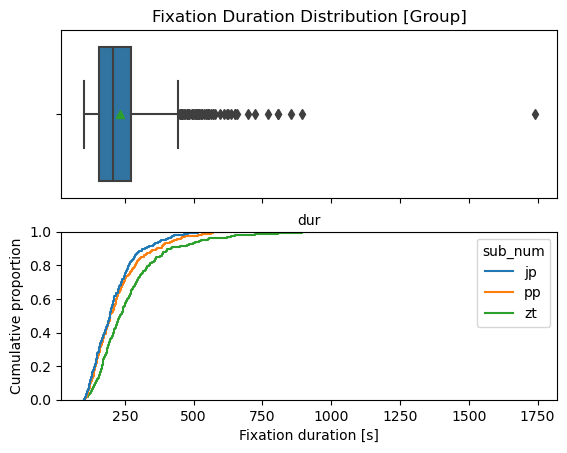

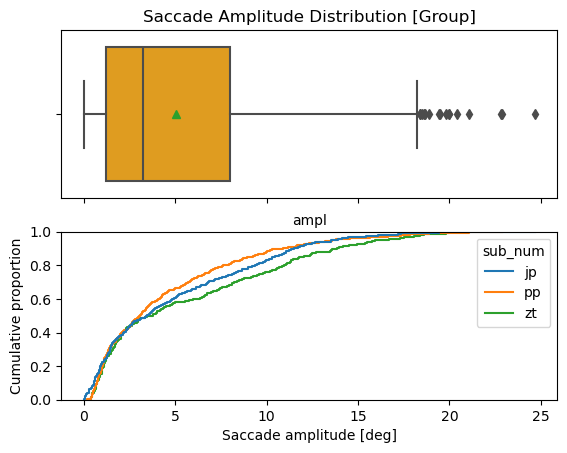

In [83]:
plot_eye_movement_distributions_group_plotly()
plot_eye_movement_distributions_group()

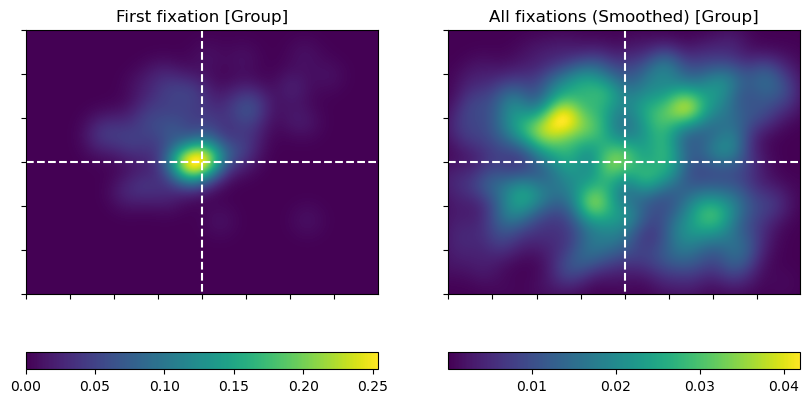

In [85]:
#plot_fixations_semantic_group()
#plot_fixations_salience_group()
plot_heatmap_group()
#plot_eye_movement_distributions_group()

<font size=5>Step 2: The role of instructions

<font size=3>Think about the instructions of the task. 

<font size=3>•	How do you think instructions relate to the different measurements to studied? 

<font size=3>•	What other instructions could have been given for the task with the present set of images (1-2 examples)? 

<font size=3>•	Make hypotheses about the potential results and how they would be similar/different from your own/the group’s results.
